## 라이브러리 불러오기

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import dlib
import cv2
import math
from skimage.feature import hog
from skimage import exposure
import copy

## Step 0. 계획  
1) open CV 사용해서 얼굴에 고양이 스티커 붙이기  
- 기본내용 진행하면서 다시 복습하기  

2)  기울어진 얼굴에 고양이 사진 붙여보기 
- 사진을 일정 기울기로 바꿔 비교해보기

3) 얼굴의 일부분이 가려진 사진(색변환이 애매한)으로 사진 붙여보기
- 얼굴의 기준이 모호한 사진으로  얼굴 detecting 성능 확인하기

4) 2인/3인 스티커 붙여보기
- 다인 landmark 비교   

5) 사람이 아닌 동물, 블러처리된 사람, 마스크낀사람, 어두운 곳에서 촬영된 사람도 landmark 형성 하는지 시도해보기  
- 사람을 닮은 동물, 멀리있는 사람, 마스크 낀 사람 등의 사진에서 landmark를 뽑아낼 수 있는지 확인

## Step 1. 스티커 구하기 or 만들기

---
스티커는 만들거나 구할 수 있다. ppt, 포토샵등을 이용해서 직접 만들 수 있다고 하지만,,, 귀찮으니 다운받아 붙여보자!  

- 고양이 수염 이미지를 다운로드
- 셀카 이미지도 촬영

스티커 이미지로 사용되는 파일은 배경이 투명한 png로 하자

## Step 2. 얼굴 검출 & 랜드마크 검출 하기
---
dlib을 사용해 얼굴의 bounding box 위치와 landmark의 위치를 찾아보자

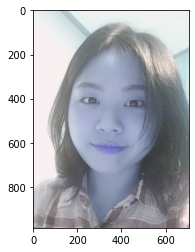

In [ ]:
my_image_path = '/content/drive/MyDrive/COLAB_data/face.jpeg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지 불러오기
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관
plt.imshow(img_bgr)
plt.show()

open CV의 특징으로 빨간색 - 파란색이 변경되어 나타난다.  
따라서 다시 RGB 컬러로 보정해주자

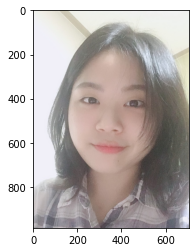

In [ ]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지말자
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

dlib의 `face detector`를 이용해서 얼굴을 찾아보자.

In [ ]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()
#detector_hog 사용해서 얼굴의 bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("bounding box 추출완료:)")

bounding box 추출완료:)


#### Image Pyramid관련 이런저런 테스트  
---
- 위에서 사용한 `detector_hog`의 두 번째 파라미터는 '이미지 피라미드의 수'라고 한다. 이미지를 크게 키워(upsampling) 뜯어봄으로 얼굴 윤곽을 더 자세히 볼 수 있다고 한다. 자세한 원리를 알기전에 한번 내 사진으로 hog를 적용시켜보쟈!
- 찾아보니 윤곽찾는 방법으로 laplacian, sobelx, sobely를 주로 사용한다고 해서 한번 시도해 보았다.

In [ ]:
# 참고 페이지에 올려준 pyrDown, pyrUp 예제
img = cv2.imread('/content/drive/MyDrive/COLAB_data/face.jpeg')
img.shape

(986, 706, 3)

In [ ]:
GAD = cv2.pyrDown(img)
GAD.shape

#(493, 353, 3)로 2배 감소함

(493, 353, 3)

In [ ]:
GAU = cv2.pyrUp(GAD)
GAU.shape

#원래 사이즈로 돌아감

(986, 706, 3)

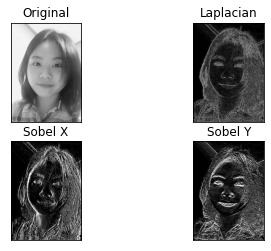

In [ ]:
#라플래시안 써보기
img = cv2.imread('/content/drive/MyDrive/COLAB_data/face.jpeg', 0)
laplacian = cv2.Laplacian(img,cv2.CV_8U,ksize=5)
sobelx = cv2.Sobel(img,cv2.CV_8U,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_8U,0,1,ksize=5)
plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.show()


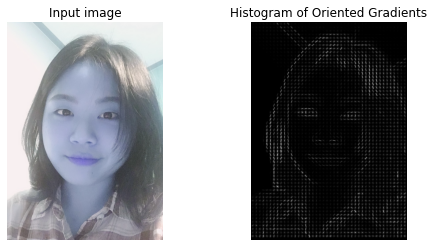

In [ ]:
image = cv2.imread('/content/drive/MyDrive/COLAB_data/face.jpeg')
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

오 HOG를 하면 이런식으로 색상변환값을 표현한다. 신기해라..
이런저런것은 그만하고 스티커 붙이기로 돌아가자!

---

rectangles[[(161, 333) (546, 718)]]


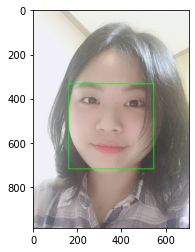

In [ ]:
#찾은 얼굴 출력
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

얼굴은 역시 잘 찾고 있으니, 이제 얼굴에 랜드마크를 콕콕 찍어줍시다.  
face landmark는 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용한다고 한다. 이전과정에서 얼굴을 얼마나 잘 찾아내느냐도 마지막 스티커 붙이는 과정중에 꽤나 핵심적인 요소 같다.

### Dlib landmark localization (top-down 방식)  

- bounding box를 찾고 box 내부의 keypoint를 예측하는 방식

In [15]:
model_path = '/content/drive/MyDrive/COLAB_data/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("landmark 모델 입력완료:)")

landmark 모델 입력완료:)


In [ ]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark 찾아내기
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


In [ ]:
print(list_landmarks)

[[(160, 417), (157, 472), (161, 524), (171, 574), (189, 620), (216, 660), (249, 696), (285, 726), (330, 737), (378, 734), (425, 715), (470, 690), (510, 658), (540, 615), (557, 563), (568, 510), (573, 455), (183, 357), (212, 333), (249, 326), (287, 336), (320, 355), (398, 360), (434, 347), (473, 344), (510, 354), (539, 379), (354, 413), (350, 450), (346, 486), (342, 523), (298, 547), (318, 555), (341, 562), (365, 558), (388, 553), (221, 408), (246, 396), (274, 399), (298, 422), (270, 423), (242, 420), (416, 431), (443, 411), (472, 411), (497, 426), (473, 435), (444, 435), (260, 610), (292, 601), (321, 594), (340, 600), (361, 597), (394, 607), (429, 620), (391, 642), (359, 650), (336, 650), (315, 646), (289, 634), (275, 613), (319, 617), (339, 621), (360, 621), (416, 621), (360, 621), (339, 621), (318, 618)]]


이제 랜드마크를 잘 찾았는지 영상에 출력해봅시다

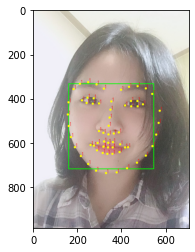

In [ ]:
for idx, landmark in enumerate(list_landmarks):
    for point in landmark:
        cv2.circle(img_show, point, 5, (0, 255, 255), -1)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img_show, str(idx+1), point, font, 0.8, (0, 0, 255), 1, cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

머리카락에 가려진 부분도 잘 예측하여 콕콕 찍어준것을 확인할 수 있습니다.  
(조금 갸름하게 찍어줬네욤...홍홍)  

번호까지 매겨보고 싶었는데 숫자가 다 1로 나온다.. 왜때문이지? 앞에서 numbering을 안해서 그런거같은데 나중에 시간나면 더 추가적으로 해보자  
[68점 표시](https://intrepidgeeks.com/tutorial/python-3-uses-dlib-197-to-realize-the-representation-of-68-facial-feature-points)

## Step 3. 스티커 적용 위치 확인하기
---
고양이 수염이 적용 될 위치를 landmark를 사용해서 계산해보자

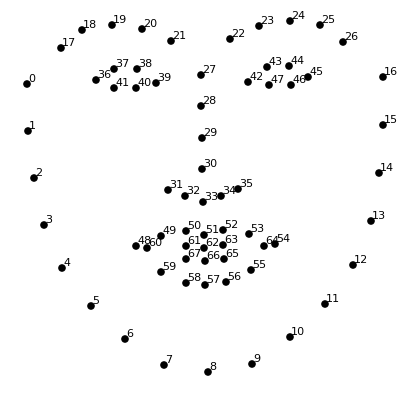

고양이코 스티커를 붙일것이기때문에   
- 스티커의 크기는 하기와 같이 정했다. 
    + W : Box size
    + H : Box size의 2/3  

그러면, 중심점을 31번 으로 정하고 거리를 조정해보자.



In [ ]:
H2 = dlib_rect.width()
w = dlib_rect.width()
h = (2 * H2) // 3


print('Box size의 크기(W)는: ', w)
print('Box size의 1/2(H)은: ', h)

Box size의 크기(W)는:  386
Box size의 1/2(H)은:  257


In [ ]:
#좌표를 먼저 확인해 보겠습니다.

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[31]) # 코끝은 31번!
    x = landmark[31][0]
    y = landmark[31][1]

    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(298, 547)
(x,y) : (298,547)
(w,h) : (386,257)


이제 스티커 이미지를 해당 w,h 사이즈로 불러주고 원본 이미지에 적용해봅시다!

## Step 4. 스티커 적용하기

In [ ]:
sticker_path = '/content/drive/MyDrive/COLAB_data/cw.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(257, 386, 3)


In [ ]:
refined_x = x - ((2 * w) //5)
refined_y = y - h //2
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (144,419)


In [ ]:
#행/열 정보로 바꾸면 행을 날려야 y축으로 변경이 됨
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (144,419)


In [ ]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
print("스티커 부착 완료:)!")

스티커 부착 완료:)!


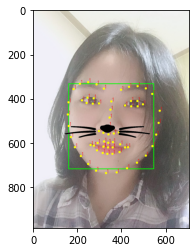

In [ ]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

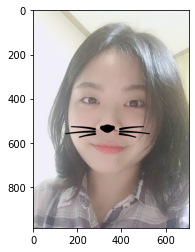

In [ ]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 번외 1) 기울어진 얼굴에 고양이 사진 붙여보기

---

- 스티커가 정면의 사진엔 잘 붙는 것을 확인했다.  

그럼 기울어진 사진엔 어떻게 되는지 한번 확인해보자.


### (1) 얼굴 검출 & 랜드마크 검출 하기

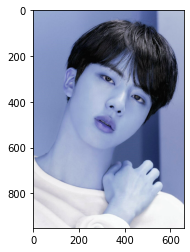

In [ ]:
my_image_path = '/content/drive/MyDrive/COLAB_data/jin.jpeg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지 불러오기
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관
plt.imshow(img_bgr)
plt.show()

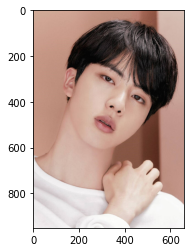

In [ ]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지말자
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

휴... 스트레스가 날아가는 외모다^_^ㅎㅎ

In [ ]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()
#detector_hog 사용해서 얼굴의 bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("bounding box 추출완료:)")

bounding box 추출완료:)


rectangles[[(161, 247) (546, 632)]]


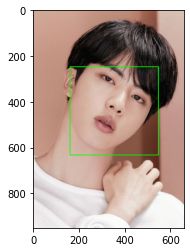

In [ ]:
#찾은 얼굴 출력
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

천상의 외모라그런지ㅎㅎㅎㅎㅎㅎ   
기울어져서 그런지ㅎㅎㅎㅎㅎ  

얼굴의 크기를 완벽하게 찍어내진 못하는 것 같다

그럼 landmark는 콕콕콕 잘 잡아주는지 확인해보자!


In [ ]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark 찾아내기
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


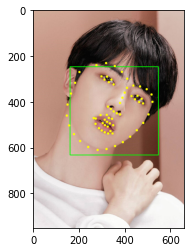

In [ ]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 5, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

오,, 기울어져있어 landmark가 face box 밖에 찍혀있긴하지만, 그래도 모양은 잘 잡아낸 것을 알 수 있습니다. 

### (2) 스티커 적용 위치 확인하기

In [ ]:
H2 = dlib_rect.width()
w = dlib_rect.width()
h = (2 * H2) // 3


print('Box size의 크기(W)는: ', w)
print('Box size의 1/2(H)은: ', h)

Box size의 크기(W)는:  386
Box size의 1/2(H)은:  257


In [ ]:
#좌표를 먼저 확인해 보겠습니다.

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[31]) # 코끝은 31번!
    x = landmark[31][0]
    y = landmark[31][1]

    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(326, 421)
(x,y) : (326,421)
(w,h) : (386,257)


### (3) 스티커 적용하기

In [ ]:
sticker_path = '/content/drive/MyDrive/COLAB_data/cw.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(257, 386, 3)


In [ ]:
refined_x = x - ((2 * w) //5)
refined_y = y - h //2
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (172,293)


In [ ]:
#행/열 정보로 바꾸면 행을 날려야 y축으로 변경이 됨
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (172,293)


In [ ]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
print("스티커 부착 완료:)!")

스티커 부착 완료:)!


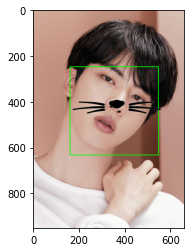

In [ ]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

역시 아무런 처리를 하지 않으니 일직선으로 붙어있는 것을 알 수 있다.  
그럼 본래 취지대로 각도를 틀어볼까?   
​
 



### (4)이미지 회전각도에 맞춰 스티커 적용하기

---

먼저는 인물의 각도를 측정할 수 이을 만한 축을 뭘로 잡을지 정하자.  

나는 코축(27-30)을 기준으로 각도를 구해보기로했다.  
그리고 그를 기준으로 삼각함수인 탄젠트를 이용해 기울기인 세타값을 구하기로 했다.  

그렇다면 세타를 구하기 위한 식은  
tanθ =  (y30 −y27) / (x30 −x27)이 될 것이다.  
(x, y는 이미지의 좌측 상단이 0,0이라는 것을 잊지말자)
​
 

In [ ]:
tan_theta = (landmark[30][0]-landmark[27][0])/(landmark[30][1]-landmark[27][1])
theta = np.arctan(tan_theta)
print(theta)

-0.4266274931268761


-0.4266....의 값이 나왔습니다.  
여기서 우리가 알고있는 각도(°)로 변경하기 위해서는 θ * 180/π 를 해줘야 한다고 합니다..(아련한 삼각함수... 호도법....)  

이어서 진행해줍시다!​
 

In [ ]:
rotate_angle = theta *180/math.pi
print(rotate_angle)

-24.443954780416536


-24.4439... 의 값이 나왔습니다. 
약 24.5도 정도 기울어진 것으로 보면 되겠네요~!  

그럼 이 각도를 스티커에 적용해줍시다!

(257, 386, 3)


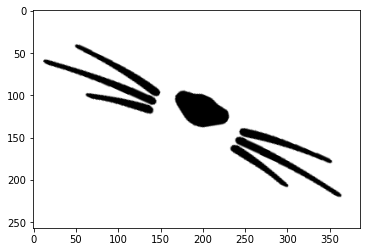

In [ ]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR,borderValue=(255,255,255))
  return result

img_rotate = rotate_image(img_sticker,rotate_angle)
print(img_rotate.shape)
plt.imshow(img_rotate)
plt.show()

이쁘게 기울어진 스티커가 나왔습니다.  

그럼 우리 진 얼굴에 붙여줘볼까욥???ㅎㅎㅎㅎ

In [ ]:
sticker_area = img_bgr[refined_y:refined_y+img_rotate.shape[0],refined_x:refined_x+img_rotate.shape[1]]
img_show[refined_y:refined_y+img_rotate.shape[0], refined_x:refined_x+img_rotate.shape[1]] = np.where(img_rotate==255,sticker_area,img_rotate).astype(np.uint8)
print("회전된 스티커 부착 완료:)!")

회전된 스티커 부착 완료:)!


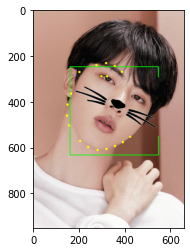

In [ ]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

이제 np.where을 사용해 확인해봅시다!

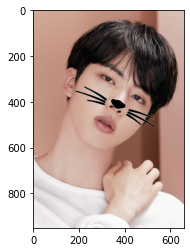

In [ ]:
sticker_area = img_bgr[refined_y:refined_y +img_rotate.shape[0], refined_x:refined_x+img_rotate.shape[1]]
img_bgr[refined_y:refined_y +img_rotate.shape[0], refined_x:refined_x+img_rotate.shape[1]] = \
    np.where(img_rotate==255,sticker_area,img_rotate).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

ㅋㅑ.... 극락....★☆  

보기가 좋네요...^_^

## 번외 2) 얼굴의 일부분이 가려진 사진으로 스티커 붙여보기

---

HOG는 이미지에서 색상의 변화량을 통해 얼굴을 잡아낸다고하는데, 그럼 손에 얼굴을 올린, 혹은 얼굴을 가려 얼굴을 제대로 확인하기 어려운 사진은 어떻게 detecting할지 궁금해서 진행해본다!

### (1) 얼굴 검출 & 랜드마크 검출 하기

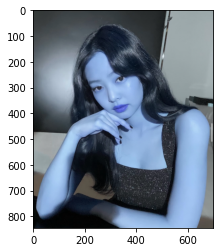

In [ ]:
my_image_path = '/content/drive/MyDrive/COLAB_data/jenny.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지 불러오기
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관
plt.imshow(img_bgr)
plt.show()

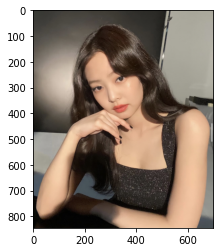

In [ ]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지말자
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

ㅎㅏ.... 언니......

In [ ]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()
#detector_hog 사용해서 얼굴의 bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("bounding box 추출완료:)")

bounding box 추출완료:)


rectangles[[(221, 242) (407, 428)]]


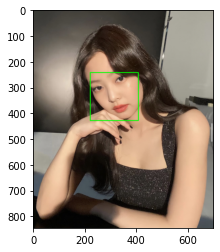

In [ ]:
#찾은 얼굴 출력
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

오... 아까 jin사진 처럼 정사각형 안에 얼굴을 담아낸다.  
어디 landmark도 잘 뽑는지 확인해보자

In [ ]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark 찾아내기
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


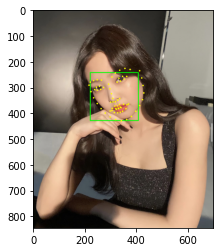

In [ ]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 3, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

###(2)스티커 적용 위치 확인하기

얼굴 box의 사이즈가 작게 잡혔으니 이번엔 스티커의 넓이를 대각선의 길이로 잡아볼까요?

피타고랏으 형님 소환합시다

In [ ]:
#좌표를 먼저 확인

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    h = dlib_rect.width()
    w = int((2 * (h ** 2)) ** 0.5)
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(308, 342)
(x,y) : (308,249)
(w,h) : (264,187)


### (3) 회전에 맞춰 스티커 적용하기

In [ ]:
sticker_path = '/content/drive/MyDrive/COLAB_data//heart.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(187, 264, 3)


이미지 시작점에 맞춰서 refined 해주기!

In [ ]:
refined_x = x - (2 * w // 3)
refined_y = y - h
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (132,62)


혹시 모르니 사진 밖으로 나가는 경우를 미리 처리해줍시다

In [ ]:
#행/열 정보로 바꾸면 행을 날려야 y축으로 변경이 됨
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (132,62)


그리고 이번에도 얼굴이 기울어져있으니, 각도를 틀어 스티커를 준비해줍시다.

In [ ]:
tan_theta = (landmark[30][0]-landmark[27][0])/(landmark[30][1]-landmark[27][1])
theta = np.arctan(tan_theta)
rotate_angle = theta *180/math.pi
print(rotate_angle)

16.220193695602784


16도 정도 틀어졌네요! 다시 슝슝

(187, 264, 3)


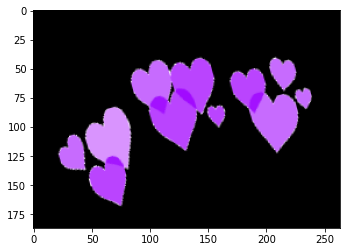

In [ ]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR,borderValue=(0,0,0))
  return result

img_rotate = rotate_image(img_sticker,rotate_angle)
print(img_rotate.shape)
plt.imshow(img_rotate)
plt.show()

In [ ]:
sticker_area = img_bgr[refined_y:refined_y+img_rotate.shape[0],refined_x:refined_x+img_rotate.shape[1]]
img_show[refined_y:refined_y+img_rotate.shape[0], refined_x:refined_x+img_rotate.shape[1]] = np.where(img_rotate==0,sticker_area,img_rotate).astype(np.uint8)
print("회전된 스티커 부착 완료:)!")

회전된 스티커 부착 완료:)!


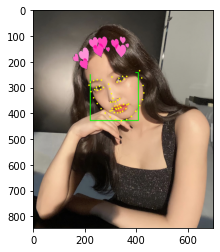

In [ ]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

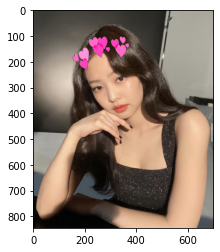

In [ ]:
sticker_area = img_bgr[refined_y:refined_y +img_rotate.shape[0], refined_x:refined_x+img_rotate.shape[1]]
img_bgr[refined_y:refined_y +img_rotate.shape[0], refined_x:refined_x+img_rotate.shape[1]] = \
    np.where(img_rotate==0,sticker_area,img_rotate).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

아... 이쁘네요....ㅎㅎ....  

## 번외3) 2인/3인 스티커 붙여보기

---


### (1) 얼굴 검출 & 랜드마크 검출하기

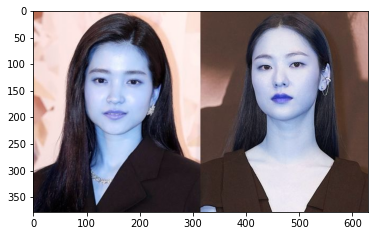

In [ ]:
my_image_path = '/content/drive/MyDrive/COLAB_data/2inin.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지 불러오기
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관
plt.imshow(img_bgr)
plt.show()

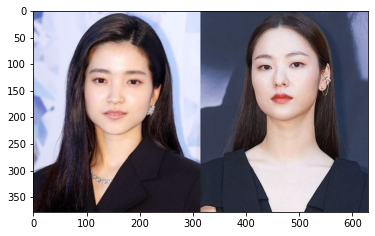

In [ ]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지말자
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [ ]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()
#detector_hog 사용해서 얼굴의 bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("bounding box 추출완료:)")

bounding box 추출완료:)


rectangles[[(96, 96) (225, 225)], [(397, 67) (526, 196)]]


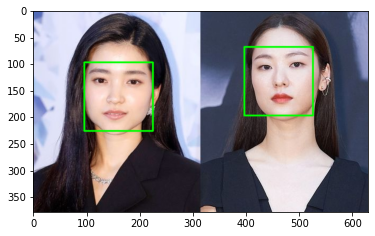

In [ ]:
#찾은 얼굴 출력
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [ ]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark 찾아내기
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


In [ ]:
#리스트 랜드마크를 인물마다 한번 따줘봅니다
print(list_landmarks[0][30][0])
print(list_landmarks[1][30][0])

154
462


In [ ]:
#리스트를 그대로 옮겨줍니다
list_landmarks2 = copy.deepcopy(list_landmarks)
print(list_landmarks2)

[[(96, 130), (96, 147), (97, 164), (99, 180), (103, 195), (112, 208), (124, 219), (137, 229), (152, 232), (168, 230), (183, 222), (198, 212), (210, 201), (217, 187), (221, 170), (224, 155), (227, 138), (104, 116), (113, 109), (124, 108), (136, 109), (148, 114), (170, 115), (182, 111), (194, 111), (206, 113), (215, 121), (157, 130), (156, 142), (155, 154), (154, 165), (143, 172), (148, 174), (154, 176), (160, 174), (166, 173), (116, 131), (124, 127), (132, 128), (139, 134), (131, 135), (123, 134), (177, 135), (184, 131), (193, 131), (200, 134), (193, 137), (185, 137), (131, 193), (140, 188), (147, 185), (154, 187), (160, 186), (168, 188), (177, 193), (168, 200), (159, 203), (153, 203), (146, 203), (139, 199), (136, 193), (147, 191), (153, 192), (160, 192), (173, 193), (159, 193), (153, 194), (147, 193)], [(409, 108), (410, 124), (413, 140), (416, 154), (420, 170), (428, 184), (440, 194), (455, 202), (471, 205), (488, 201), (504, 193), (519, 183), (529, 170), (535, 154), (538, 137), (540

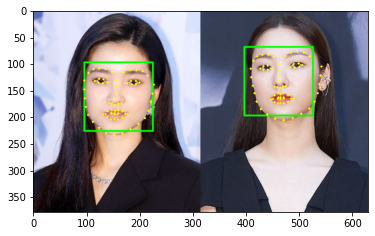

In [ ]:
for landmark in list_landmarks2:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

오.... 1인에서 아무런 코드 변화가 없지만 자동으로 다인을 인식하는 것을 볼 수 있다.

###(2)스티커 적용 위치 확인하기

In [ ]:
H2 = dlib_rect.width()
w = dlib_rect.width()
h = (2 * H2) // 3

print('Box size의 크기(W)는: ', w)
print('Box size의 1/2(H)은: ', h)

Box size의 크기(W)는:  130
Box size의 1/2(H)은:  86


In [ ]:
#2인 코 위치확인
for i in range(2):
    print(list_landmarks[i][31][0])

143
454


In [ ]:
#위치확인
for i in range(2):
    x_i = list_landmarks[i][31][0]
    y_i = list_landmarks[i][31][1]
    print(x_i, y_i)

143 172
454 142


와우 사람이 2명이니까 (x,y), (w,h)의 값을 2개씩 불러오는 것을 알 수 있다!

### (3)스티커 적용하기

In [ ]:
sticker_path = '/content/drive/MyDrive/COLAB_data/cw.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(86, 130, 3)


In [ ]:
for i in range(len(list_landmarks)):
    x_i = list_landmarks[i][31][0]
    y_i = list_landmarks[i][31][1]

    refined_x_i = x_i - ((2 * w) // 5)
    refined_y_i = y_i - h //2

    sticker_area = img_show[refined_y_i:refined_y_i+img_sticker.shape[0], refined_x_i:refined_x_i+img_sticker.shape[1]]
    img_show[refined_y_i:refined_y_i+img_sticker.shape[0], refined_x_i:refined_x_i+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
    print("스티커 부착 완료:)!")
    

스티커 부착 완료:)!
스티커 부착 완료:)!


다인이 되어 list_landmark에 값이 `[n번째 사람얼굴][n번째 점][x or y]`로 나눠져있어 그것을 for문으로 돌려 sticker area를 부여해줬다....  
힘들었다.... 어디 잘 붙었는지 확인해보자!

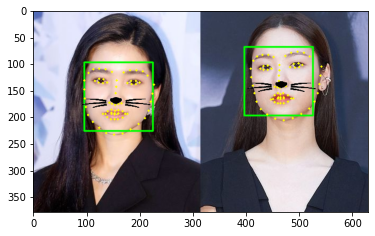

In [ ]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

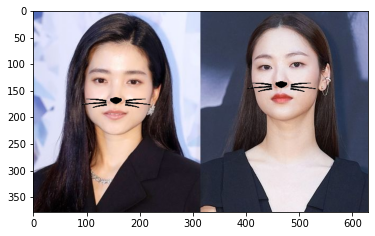

In [ ]:
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

흑.... 뿌듯하다.. 

## 번외4) 사람이 아닌 동물, 블러처리된 사람, 마스크낀사람, 어두운 곳에서 촬영된 사람도 landmark 형성 하는지 시도해보기  
- 사람 닮은 동물도 사람의 얼굴로 인식할까?
- 얼굴의 형상이 흐릿하다면?
- 마스크를 껴서 눈코만 확인이 가능하다면?
- 반대로 눈을 확인할 수 없다면?
- 어두운 곳에서 눈만 확인되는 사람이라면?

이런저런 사진으로 landmark 형상으르 뽑아보자!

### case1. 눈이 가려진 사람

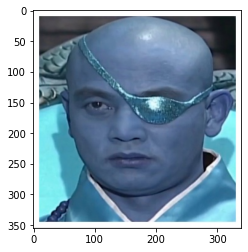

In [ ]:
my_image_path = '/content/drive/MyDrive/COLAB_data/gy1.jpeg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지 불러오기
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관
plt.imshow(img_bgr)
plt.show()

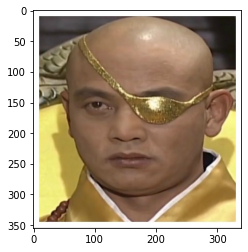

In [ ]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [ ]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()
#detector_hog 사용해서 얼굴의 bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("bounding box 추출완료:)")

bounding box 추출완료:)


rectangles[[(43, 93) (266, 316)]]


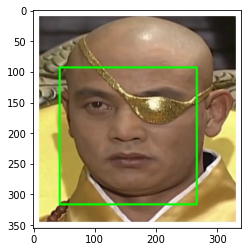

In [ ]:
#찾은 얼굴 출력
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

오 얼굴 매칭까진 완료!

In [ ]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark 찾아내기
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


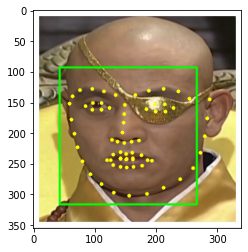

In [ ]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 3, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

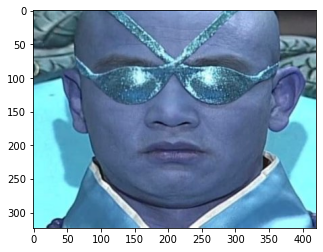

In [ ]:
my_image_path = '/content/drive/MyDrive/COLAB_data/gy2.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지 불러오기
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관
plt.imshow(img_bgr)
plt.show()

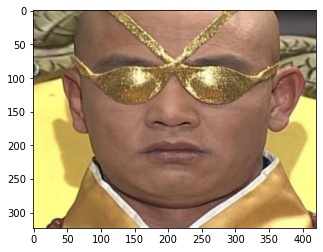

In [ ]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [ ]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()
#detector_hog 사용해서 얼굴의 bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("bounding box 추출완료:)")

bounding box 추출완료:)


rectangles[[(82, 23) (349, 290)]]


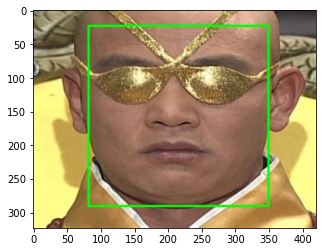

In [ ]:
#찾은 얼굴 출력
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [ ]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark 찾아내기
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


과연 결과는?ㅋㅋㅋㅋㅋㅋ

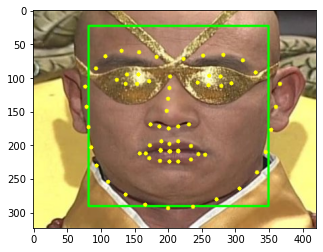

In [ ]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 3, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

아 눈위치를 찍어주네...?ㅋㅋㅋㅋㅋㅋ  
없는 눈도 만들어주는 신기한 CV2.....!!!!

### case2. 어두운 곳에서 찍힌 사람   
---
사진은 어두운데에서 찍힌 조나단이다! 그냥봐도 눈과 입만보이는데 과연 컴퓨터는 구별할 수 있을지 궁금하다.

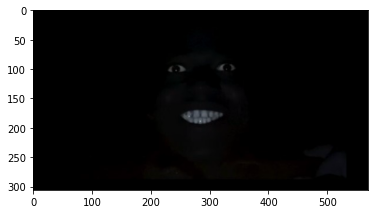

In [3]:
my_image_path = '/content/drive/MyDrive/COLAB_data/black.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지 불러오기
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관
plt.imshow(img_bgr)
plt.show()

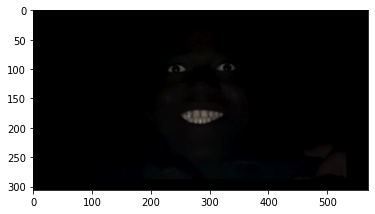

In [4]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [5]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()
#detector_hog 사용해서 얼굴의 bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("bounding box 추출완료:)")

bounding box 추출완료:)


rectangles[]


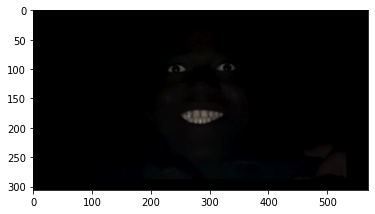

In [6]:
#찾은 얼굴 출력
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

아... 눈과 입으로만은 얼굴을 인식할 수 없나보다...  하긴 저게 눈인지 입인지 컴퓨터가 알 수가 없으니까...?

### case3. mask낀 사람 
---
- 입과 코를 추출하지 못하는 mask 낀 사람과 코만 추출하지 못하는 입이 뚫린 mask 낀 사람은 어떻게 할까?

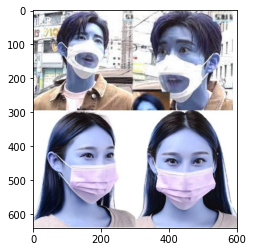

In [10]:
my_image_path = '/content/drive/MyDrive/COLAB_data/mask3.JPG'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지 불러오기
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관
plt.imshow(img_bgr)
plt.show()

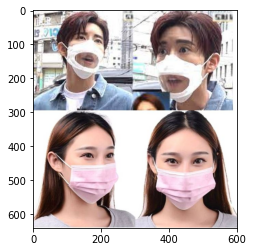

In [11]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [12]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()
#detector_hog 사용해서 얼굴의 bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("bounding box 추출완료:)")

bounding box 추출완료:)


rectangles[[(97, 366) (283, 552)], [(345, 387) (531, 573)], [(324, 57) (510, 242)]]


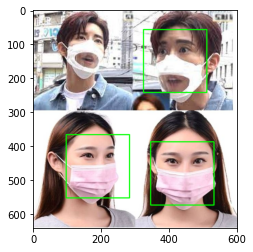

In [13]:
#찾은 얼굴 출력
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

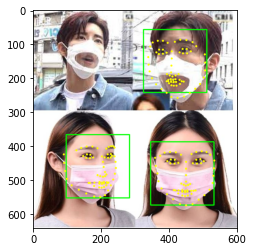

In [16]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark 찾아내기
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 3, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

오 사실 그냥 마스크 낀 사람은 못찾아내고 입뚫린 마스크 낀 사람은 찾을 줄 알았는데 의외로 마스크 낀 사람을 더 잘 찾는 게 신기하다...  
마스크의 종류는 중요하지 않은 것 같고, 비슷한 각도로 돌아간 아래 그림은 찾았는데 위에 그림은 못찾은 이유는 아마 해상도 차이? 이지 않을까 싶다.

### case4. 사람닮은 동물

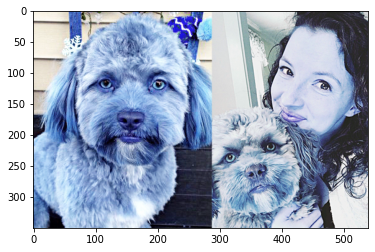

In [17]:
my_image_path = '/content/drive/MyDrive/COLAB_data/god.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지 불러오기
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관
plt.imshow(img_bgr)
plt.show()

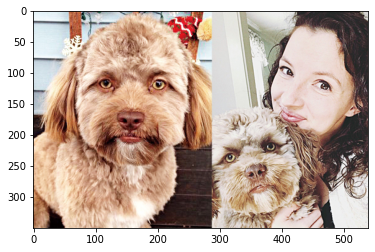

In [18]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

ㅋㅋㅋ진짜 사람처럼 생기긴 했는데, 얼굴 윤곽이 뚜렷하지 않아서 잘 detect를 못할 것 같기도 하다..  
우선 고!

rectangles[[(97, 366) (283, 552)], [(345, 387) (531, 573)], [(324, 57) (510, 242)]]


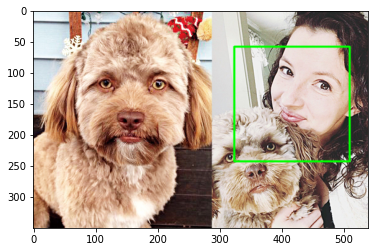

In [19]:
#찾은 얼굴 출력
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

아 역시 동물은 추출하지 못하넴... 윤곽때문인가?? 흠....

## 회고
---
- 일상에서 흔히 쓰는 스노우나 다른 카메라 어플에서 얼굴에 스티커 붙여주는 과정이 어떻게 진행되는지 알게 되어 신기했다. 눈코입 각 위치에 맞는 점을 붙여주고 그 점들을 기준으로 거리를 조정해서 스티커를 붙이다니... 똑똑하다 똑똑해..!!  
- 그리고 NLP를 하다가 CV를 처음 접하게 되니 이게 눈으로 바로 확인이 가능하니까 재밌으면서도, CV쪽이 은근 각도나 3차원적 계산이 들어가서 더 어려울지도 모르겠는 생각이 들었다. 이번 얼굴의 각도를 찾는 부분처럼 만약 멀리있는 사물을 detect하여 평면화 시킨다고 하면, 3차원의 각도와 원근법 등을 계산해서 뽑아내야하는 것 아닌가...? 쉽지 않을 것 같다...  
- 하지만 그래도 확실히 스스로 가설들을 세워두고 그를 확인해가는 작업은 재밌었다! 역시 코딩의 재미는 이렇게 생각한 것들을 바로바로 확인해 볼 수 있는 것 아닐까? 홍홍홍   
- 그래도 다양한 가설들을 세웠다는 것은 반대로 그만큼 내가 이 코드의 원리를 알지 못했다는 것의 반증이 아닐까 싶다. 사실 HOG법이나 얼굴의 점을 찍어내는 기술의 원리를 먼저 이해하고 진행하려고 했으나, 시간에 쫓겨 다음으로 미룬게 사실이다. 미리미리 시간을 확보하고 더 깊게 이해할 수 있는 실습을 진행하자. 
- 2인 스티커를 붙이면서 내가 Python의 기본적인 내용을 많이 놓치고 있다는 것을 다시 한번 느낀다. 완성을 해서 뿌듯하긴 하다만,,,, 재빈님의 도움을 통해 만든 것이라 스스로 자부심을 갖기엔 아직 부족하다. 그리고 내 생각대로 코드를 짜려면 다양한 경험? 코드짜는 경험을 더 많이 해봐야겠다는 생각이 든다. 코딩도장... 백준문제.... 도전해볼까....
- 이번엔 상대적으로 가벼운 실습이었지만(이전 NLP 너무 어려웠다...) 이번 실습도 재밌었고! 다음엔 준병님이 한 것처럼 68개의 점이 아닌 4백여개의 점을 통한 이미지 처리도 해보고 싶다! ㅎㅎ  